In [ ]:
##CoLab SetUp
%load_ext autoreload
%autoreload 2
import os
import sys
import time

####
from google.colab import drive
drive.mount('/content/drive')
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Graph_Convolutional_Networks_Node_Classification-master'
GOOGLE_DRIVE_PATH = os.path.join('/content','drive', 'My Drive', 'Colab Notebooks', 'GCNConv', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))
#sys.path.append(GOOGLE_DRIVE_PATH)
os.chdir(GOOGLE_DRIVE_PATH)
os.environ["TZ"] = "US/Eastern"
time.tzset()


Mounted at /content/drive
['README.md', 'requirements.txt', 'cora', 'Tensorboard_GCN_cora', 'Node_Classification_GCN_Semi-Sup_CORA.ipynb']


In [ ]:
!pip install spektral
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from spektral.data.loaders import SingleLoader
from spektral.datasets.citation import Citation
from spektral.layers import GCNConv
from spektral.models.gcn import GCN
from spektral.transforms import LayerPreprocess

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 129 kB 18.4 MB/s 


In [ ]:
import numpy as np
import os
import networkx as nx
import tensorflow as tf
import tensorflow.keras
import spektral

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from spektral.layers import GCNConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
import networkx as nx

In [ ]:
from spektral.data import BatchLoader

In [ ]:
loader = BatchLoader(dataset, batch_size=600)
spektral.data.Dataset

In [ ]:
learning_rate = 1e-2
seed = 0
epochs = 200
patience = 10
data = "cora"

tf.random.set_seed(seed=seed)  # make weight initialization reproducible



# Load data
dataset = Citation(data)
#normalize_x=True
#transforms=[LayerPreprocess(GCNConv)]


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
# We convert the binary masks to sample weights so that we can compute the
# average loss over the nodes (following original implementation by
# Kipf & Welling)
def mask_to_weights(mask):
    return mask.astype(np.float32) / np.count_nonzero(mask)


weights_tr, weights_va, weights_te = (
    mask_to_weights(mask)
    for mask in (dataset.mask_tr, dataset.mask_va, dataset.mask_te)
)

In [ ]:
model = GCN(n_labels=dataset.n_labels)
model.compile(
    optimizer=Adam(learning_rate),
    loss=CategoricalCrossentropy(reduction="sum"),
    weighted_metrics=["acc"],
)

In [ ]:
from networkx.algorithms.centrality.group import prominent_group
#Remodel architecture based on old code
loader_tr = SingleLoader(dataset, sample_weights=weights_tr)
loader_va = SingleLoader(dataset, sample_weights=weights_va)
A = dataset[0].a

G = nx.from_scipy_sparse_matrix(A)
print(nx.info(G))
X = np.array(dataset[0].x,dtype=int) #X is the features
N = X.shape[0] #number of nodes
F = X.shape[1]
labels = np.array(dataset[0].y,dtype = int)

print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', labels)
num_classes = 7 





Graph with 2708 nodes and 5278 edges

Number of nodes (N):  2708

Number of features (F) of each node:  1433

Categories:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# Parameters
channels = 16           # Number of channels in the first layer
dropout = 0.5           # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-2    # Learning rate
epochs = 200            # Number of training epochs
es_patience = 30        # Patience for early stopping

# Preprocessing operations
A = GCNConv.preprocess(A).astype('f4')

# Model definition
X_in = Input(shape=(F, ))
fltr_in = Input((N, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GCNConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GCNConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_2, fltr_in])

# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_GCN_cora',
)
callback_GCN = [tbCallBack_GCN]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1433)]       0           []                               
                                                                                                  
 dropout_2 (Dropout)            (None, 1433)         0           ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 2708)]       0           []                               
                                                                                                  
 gcn_conv_2 (GCNConv)           (None, 16)           22928       ['dropout_2[0][0]',              
                                                                  'input_2[0][0]']            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Train model
validation_data = ([X, A], labels, dataset.mask_va)
model.fit([X, A],
          labels,
          sample_weight=dataset.mask_tr,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[
              EarlyStopping(patience=es_patience,  restore_best_weights=True),
              tbCallBack_GCN
          ])

This below is the newer codes model

In [ ]:
X_te = X[dataset.mask_te]
A_te = A[dataset.mask_te,:][:,dataset.mask_te]
y_te = labels[dataset.mask_te]
print(type(X_te))
#for el in X_te:
 # if (1 in el):
  #  print(el)
print("Features Shape:", F)
print("Nodes Shape:", N)
print("Mask test shape:"  , dataset.mask_te.shape)
print("Adj matrix shape" , A.shape)
print("Features, nodes Shape: " , X.shape)
print("Features,nodes test msk shape" , X_te.shape)
print("Adj matrix test mask shape" , A_te.shape)
y_pred = model.predict([X_te,A_te], batch_size = N)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1))
print('GCN Classification Report: \n {}'.format(report))

<class 'numpy.ndarray'>
Features Shape: 1433
Nodes Shape: 2708
Mask test shape: (2708,)
Adj matrix shape (2708, 2708)
Features, nodes Shape:  (2708, 1433)
Features,nodes test msk shape (1000, 1433)
Adj matrix test mask shape (1000, 1000)


ValueError: ignored

In [ ]:
print(np.argmax(y_pred[0]))


1


In [ ]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)
print(len(activations),activations[5].shape)


#Get t-SNE Representation
#get the hidden layer representation after the first GCN layer
x_tsne = TSNE(n_components=2).fit_transform(activations[5]) 

6 (2708, 7)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


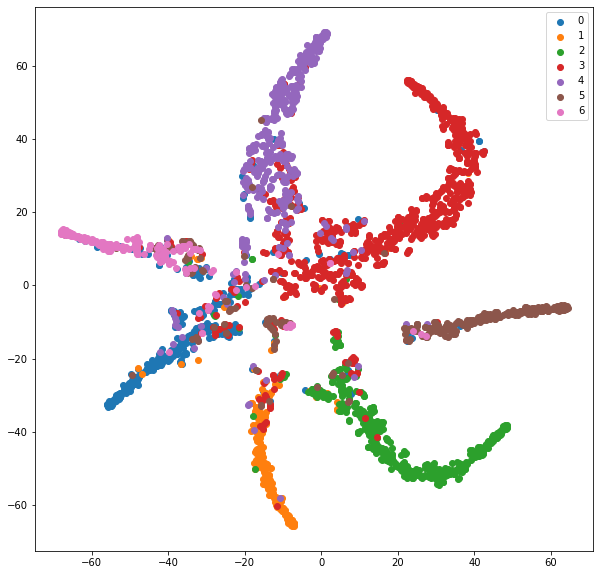

In [ ]:
def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
    
plot_tSNE(labels,x_tsne)

In [ ]:
# Train model
loader_tr = SingleLoader(dataset, sample_weights=weights_tr)
loader_va = SingleLoader(dataset, sample_weights=weights_va)
model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)],
)

In [ ]:
model.summary()

Model: "gcn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           multiple                  0         
                                                                 
 gcn_conv (GCNConv)          multiple                  22928     
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 gcn_conv_1 (GCNConv)        multiple                  112       
                                                                 
Total params: 23,040
Trainable params: 23,040
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Evaluate model
print("Evaluating model.")
loader_te = SingleLoader(dataset, sample_weights=weights_te)
eval_results = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done.\n" "Test loss: {}\n" "Test accuracy: {}".format(*eval_results))